<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/SCAREDMonodepth2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

In [1]:
!pip -q install torchmetrics
#!pip install pytorch-ignite

     |████████████████████████████████| 529 kB 13.1 MB/s 


#Download Data

In [2]:
# import gdown
# url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
# gdown.download(url,'SCARED.zip',quiet=True) 
# import os
# if not os.path.exists('/content/SCARED/'):
#   !unzip -q SCARED.zip 

from google.colab import drive
drive.mount('/content/drive')
!unzip -q drive/MyDrive/SCARED.zip

Mounted at /content/drive


In [3]:
import tarfile
import re
from collections import OrderedDict
from tqdm import tqdm
import json
import numpy as np
import gdown
json_tar_gz_url = 'https://drive.google.com/uc?id=1rrswaVdzir4feGNvDmvW56iql-L0saZL'
gdown.download(json_tar_gz_url,'d3k1_json',quiet=True) 

poses= []
with tarfile.open('d3k1_json', "r:gz") as frame_data:
  samples = frame_data.getmembers()
  for sample in tqdm(samples, desc="loading pose data", leave=False):
      with frame_data.extractfile(sample) as sample_json:
          pose = np.array(json.loads(sample_json.read())["camera-pose"])
          poses.append(pose) 
print(len(poses))
print(pose)

329
[[ 6.79565802e-01 -7.31499864e-01 -5.56609482e-02 -5.61911743e+00]
 [ 7.32502844e-01  6.80755367e-01 -3.39599501e-03 -3.42786864e-01]
 [ 4.03758211e-02 -3.84639001e-02  9.98443636e-01 -3.27258599e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#Prepare Dataloader

70 50 20
torch.Size([3, 256, 320]) torch.Size([256, 320]) tensor(0.0588) tensor(0.8471)


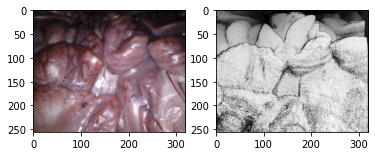

In [18]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import os

os.chdir('/content')
class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = np.nan_to_num(depth, posinf=0, neginf=0)
        depth = cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=2.5), cv2.COLORMAP_JET)
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img, depth = self.transform(img), self.transform(depth)
        return img, depth

transform_all = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

path_depth_all = glob('SCARED/*.tiff')
path_depth_train = path_depth_all[:50]
path_depth_valid = path_depth_all[50:]
print(len(path_depth_all),len(path_depth_train),len(path_depth_valid))

dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
dataset_valid = MyDataset(path_depth=path_depth_valid, transform=transform_all)
plt.subplot(121), plt.imshow(dataset_train[0][0].permute(1,2,0))
plt.subplot(122), plt.imshow(dataset_train[0][1][0], cmap='gray')
print(dataset_train[0][0].shape, dataset_train[0][1][0].shape, dataset_train[0][1].min(), dataset_train[0][1].max())

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

#Arguments

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=120, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

#Initialise pretrained model

In [6]:
!git clone https://github.com/nianticlabs/monodepth2.git
#os.chdir('monodepth2')
%cd monodepth2
import networks
from utils import download_model_if_doesnt_exist
model_name = "mono_640x192"
# model_name = "stereo_640x192"
# model_name = 'mono+stereo_640x192'

# model_name = 'mono_1024x320'
# model_name = 'stereo_1024x320'
# model_name = 'mono+stereo_1024x320'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")
pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
pose_encoder = networks.ResnetEncoder(18, "pretrained", 2)
pose_decoder = networks.PoseDecoder(encoder.num_ch_enc,1,2)#num_input_features, num_frames_to_predict_for

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

loaded_dict = torch.load(pose_encoder_path, map_location=device)
pose_encoder.load_state_dict(loaded_dict)

loaded_dict = torch.load(pose_decoder_path, map_location=device)
pose_decoder.load_state_dict(loaded_dict)

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 4.61 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/monodepth2
-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
Downloading: "http

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

#Retrain

mse (l2) = $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2$

mae (l1) = $\left\|pred_i - gt_i\right\| = \frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|$

sq rel =  $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2/gt_i$

abs rel = $\frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|/gt_i$

rmse = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2}$

rmse log = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log pred_i - \log gt_i)^2}$

appearance loss: $C_{a p}=\frac{1}{n} \sum_{i=1}^{n} \alpha \frac{1-\operatorname{SSIM}(pred_i - gt_i)}{2}+(1-\alpha)\left\|pred_i - gt_i\right\|$ $, \alpha$ was set to 0.85

disparity smoothness loss: $C_{d s}=\frac{1}{n} \sum_{i}^{n}(\partial_{x} pred_{i}) e^{-\left\|\partial_{x} Image\right\|}+(\partial_{y} pred_{i}) e^{-\left\|\partial_{y} Image\right\|}$ 

In [16]:
!mkdir weights

In [ ]:
os.chdir('/content')
%cd content
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import mean_absolute_error

import torchvision.transforms as transforms
from PIL import Image
import os


import math
import torch.nn.functional as F
import numpy as np
from torchmetrics import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)



class Photometric_Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def SSIM(self, x, y):
      C1 = 0.01 ** 2
      C2 = 0.03 ** 2

      mu_x = nn.AvgPool2d(3, 1)(x)
      mu_y = nn.AvgPool2d(3, 1)(y)
      mu_x_mu_y = mu_x * mu_y
      mu_x_sq = mu_x.pow(2)
      mu_y_sq = mu_y.pow(2)

      sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
      sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
      sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

      SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
      SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
      SSIM = SSIM_n / SSIM_d

      return torch.clamp((1 - SSIM) / 2, 0, 1)


    def forward(self, img1, img2, img = None):#output label image
      ssim = torch.mean(self.SSIM(img1,img2))
      l1 = torch.mean(torch.abs(img1 - img2))
      photometric_loss = 0.85 * ssim+ 0.15 * l1
      return photometric_loss


class Disparity_Smoothness(Photometric_Loss):
  def __init__(self):
      super(Photometric_Loss, self).__init__()  

  def gradient_x(self, img):
      # Pad input to keep output size consistent
      img = F.pad(img, (0, 1, 0, 0), mode="replicate")
      gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
      return gx

  def gradient_y(self, img):
      # Pad input to keep output size consistent
      img = F.pad(img, (0, 0, 0, 1), mode="replicate")
      gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
      return gy

  def disp_smoothness(self, depth, img):
      disp_gradients_x = self.gradient_x(depth)  # NCHW
      disp_gradients_y = self.gradient_y(depth)  # NCHW

      image_gradients_x = self.gradient_x(img)  # NCHW
      image_gradients_y = self.gradient_y(img)  # NCHW

      weights_x = torch.exp(-torch.mean(torch.abs(image_gradients_x), 1,keepdim=True))
      weights_y = torch.exp(-torch.mean(torch.abs(image_gradients_y), 1,keepdim=True))

      smoothness_x = disp_gradients_x * weights_x
      smoothness_y = disp_gradients_y * weights_y#[1,1,1280,1024]

      smoothness = torch.mean(smoothness_x) + torch.mean(smoothness_y)
      return smoothness

  def forward(self, img1, img2, img):#output label image
      ssim = torch.mean(self.SSIM(img1,img2))
      l1 = torch.mean(torch.abs(img1 - img2))
      gradient = self.disp_smoothness(img1, img)
      photometric_loss = 0.85 * ssim+ 0.15 * l1 +0.1 * gradient
      return photometric_loss

def train(model, trainloader, optimizer, criterion):
    model[0].train()
    model[1].train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        features = model[0](image_batch)
        outputs = model[1](features)
        #outputs = model(image_batch)
        if isinstance(criterion,Disparity_Smoothness):
          loss = criterion(outputs[('disp', 0)], label_batch, image_batch)
          #loss = criterion(outputs, label_batch, image_batch)
        else:  
          #loss = criterion(outputs, label_batch, image_batch)
          loss = criterion(outputs[('disp', 0)], label_batch)#[batch_size, 1, 256, 320]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model[0].eval()
    model[0].eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    rmse_all = []
    rmselog_all = []
    mae_rel_all = []
    mse_rel_all = []
    a1 = []
    a2 = []
    a3 = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            features = model[0](image_batch)
            outputs = model[1](features)
            #outputs = model(image_batch)
            outputs = outputs[('disp', 0)]
            outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
            rmse_all.append(math.sqrt(mse.item()))
            rmselog_all.append(math.sqrt(nn.MSELoss()(torch.log(outputs), torch.log(label_batch)).item()))
            mse_rel_all.append(mse.item() / label_batch[i_batch][0].detach().cpu().numpy())
            mae_rel_all.append(nn.L1Loss()(outputs, label_batch).item() / label_batch[i_batch][0].detach().cpu().numpy())
            thresh = np.maximum((label_batch / outputs).detach().cpu(), (outputs / label_batch).detach().cpu())
            # a1.append(thresh < 1.25     ).mean()
            # a2.append(thresh < 1.25 ** 2).mean()
            # a3.append(thresh < 1.25 ** 3).mean()
        return np.mean(mse_all), np.mean(ssim_all), np.mean(rmse_all), np.mean(rmselog_all), np.mean(mse_rel_all),  np.mean(mae_rel_all[0])


def main():
    seed_everything()
    args = get_args()
    # #os.chdir('SCARED')
    # path_depth_all = glob('content/SCARED/*.tiff')
    # path_depth_train = path_depth_all[:50]
    # path_depth_valid = path_depth_all[50:]

    # dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
    # dataset_valid = MyDataset(path_depth=path_depth_valid, transform=transform_all)

    # train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
    # valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    #github: https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
    # model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    #         in_channels=3, out_channels=1, init_features=32, pretrained=False)
    # model.to(device)
    encoder.to(device)
    depth_decoder.to(device)
    models = []
    models.append(encoder)
    models.append(depth_decoder)


    args.criterion = 'l1'

    if args.criterion == 'mse':        
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':        
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':        
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)
    elif args.criterion == 'photometric':
        criterion = Photometric_Loss().to(device)
    elif args.criterion == 'smoothness':
        criterion = Disparity_Smoothness().to(device)
    
    parameters = []
    parameters += list(models[0].parameters())
    parameters += list(models[1].parameters())
    optimizer = optim.AdamW(parameters, lr=1e-3)
    #optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    best_mse, best_ssim, best_rmse, best_rmselog, best_mse_rel, best_mae_rel, best_epoch = np.inf, 0, np.inf,np.inf,np.inf,np.inf,0
  
    for epoch_num in range(args.max_epochs):
        # if self.args.adjust_lr:
        #     adjust_learning_rate(self.optimizer, epoch,
        #                              self.args.learning_rate)
        #train(model, train_loader, optimizer, criterion)
        #mse, ssim, rmse, rmselog, mse_rel, mae_rel = test(model, valid_loader)
        train(models, train_loader, optimizer, criterion)
        mse, ssim, rmse, rmselog, mse_rel, mae_rel = test(models, valid_loader)
        if mse < best_mse:
            best_mse = mse
            #best_ssim = ssim
            best_epoch = epoch_num
            torch.save(models[0].state_dict(), os.path.join("weights", "{}_{}_{}.pth".format("encoder", args.criterion, best_epoch)))
            torch.save(models[1].state_dict(), os.path.join("weights", "{}_{}_{}.pth".format("decoder", args.criterion, best_epoch)))
        # if ssim > best_ssim:
        #     best_ssim = ssim
        #     best_epoch = epoch_num
     
        # if rmse < best_rmse:
        #     best_rmse = rmse
        #     best_epoch = epoch_num
        
        # if rmselog < best_rmselog:
        #     best_rmselog = rmselog
        #     best_epoch = epoch_num

        # if mse_rel < best_mse_rel:
        #     best_mse_rel = mse_rel
        #     best_epoch = epoch_num
        # if mae_rel < best_mae_rel:
        #     best_mae_rel = mae_rel
        #     best_epoch = epoch_num

           
        # print('Epoch:{}, Curr MSE(L2):{:.6f}, Curr SSIM:{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best Epoch:{}, Criterion:{}, Lr:{}'.
        #         format(epoch_num, mse, ssim, best_mse, best_ssim, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))
        # print('Epoch:{}, Curr MSE(L2):{:.4f}, Best RMSE:{:.4f}, RMSElog:{:.4f}, sq rel:{:.4f}, abs rel:{:.4f}, MSE(L2):{:.4f}, SSIM:{:.4f},  Best Epoch:{}, Criterion:{}, Lr:{}'.
        #         format(epoch_num, mse, best_rmse, best_rmselog, best_mse_rel, best_mae_rel, best_mse, best_ssim,  best_epoch, args.criterion, optimizer.param_groups[0]['lr']))
        print(mse, best_mse, best_epoch)
    weights = {}
    weights["encoder"] = []
    weights["decoder"] = []
    weights["encoder"].append("{}_{}_{:03d}.pth".format("encoder", args.criterion, best_epoch))
    weights["decoder"].append("{}_{}_{:03d}.pth".format("decoder", args.criterion, best_epoch))
if __name__ == "__main__":
    main()

[Errno 2] No such file or directory: 'content'
/content/monodepth2
Sample size- Train:50, Valid: 20
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0.1318276822566986 0
0.1318276822566986 0

# comparative visulization

In [ ]:
import gdown
url1 = 'https://drive.google.com/uc?id=1eOcmOO0osrOwwoxqZ9ujdEFhQB1FL7Hs'
gdown.download(url1,'bce_epoch110',quiet=True)
url2 = 'https://drive.google.com/uc?id=1_8XF5Moz-CCCvOiWfypUwjpFe-I8zWr6'
gdown.download(url2,'mae_epoch108',quiet=True)
url3 = 'https://drive.google.com/uc?id=1vTKtu5OWdARAWOENgIW4o6AjGYrkZOSD'
gdown.download(url3,'mse_epoch119',quiet=True)
url4 = 'https://drive.google.com/uc?id=1fNyyPYJ7SVwzAXTEGRQvw962pJYF8AI8'
gdown.download(url4,'ssim_epoch118',quiet=True)
url5 = 'https://drive.google.com/uc?id=1Dkdk2jRA3fBR92o9mIjP7IzotDq5Q7gW'
gdown.download(url5,'photo_epoch111',quiet=True)

weights = ['bce_epoch110', 'mae_epoch108', 'mse_epoch119', 'ssim_epoch118','photo_epoch111']

(input, label) = dataset_valid[42]
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#             in_channels=3, out_channels=1, init_features=32, pretrained=False)
encoder
for weight in weights:
  model.load_state_dict(torch.load('bce_epoch110'))
  model.cuda()
  feature = encoder(input[None].cuda())
  prediction = decoder(feature)


In [ ]:
plt.imshow(input.permute(1,2,0)), plt.title('input')
plt.show()
plt.imshow(label[0], cmap='gray'), plt.title('ground truth depth')
plt.show()
plt.plot(),plt.imshow(prediction[0][0].detach().cpu(), cmap='gray'), plt.title('bce epoch 110')
plt.show()
plt.plot(), plt.imshow(prediction2[0][0].detach().cpu(),cmap='gray'), plt.title('mae epoch 108')
plt.show()
plt.plot(), plt.imshow(prediction3[0][0].detach().cpu(),cmap='gray'), plt.title('mse epoch 119')
plt.show()
plt.plot(), plt.imshow(prediction4[0][0].detach().cpu(),cmap='gray'), plt.title('ssim epoch 118')
plt.show()
plt.plot(), plt.imshow(prediction5[0][0].detach().cpu(),cmap='gray'), plt.title('photometric epoch 111')
plt.show()

## reconstruction visulization

In [ ]:
class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')#cartesiam coordinates
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)#learnable parameters

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        print('-------------pixel -> camera -> depth---------------')
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)#[3,3][] #drop last colomn and last row
        print('pixel: ', pix_coords.size(), 'k_inv: ', inv_K[:, :3, :3].size(),'cam: ',cam_points.size(), 'depth:',depth.view(self.batch_size, 1, -1).size())
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points #camera multiply depth
        cam_points = torch.cat([cam_points, self.ones], 1) 

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        P = torch.matmul(K, T)[:, :3, :] #K multiply T
        print('-----------world -> camera -> pixel-------------')
        cam_points = torch.matmul(P, points) #K multiply T multiply points, from world to camera then to image
        print('KT: ', P.size(), 'point cloud: ', points.size(), '3d to 2d: ', cam_points.size())
        #cam_points to pixel coords: torch.Size([1, 3, 49152])#torch.Size([1, 2, 49152])#torch.Size([1, 1, 49152])
        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)#+ self.eps barely no change
        print('pixel coordinate: ', cam_points.shape)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        print('pix coordinate view batch, 2, h, w', pix_coords.shape)
        pix_coords = pix_coords.permute(0, 2, 3, 1)#batch, h, w, 2
        pix_coords[..., 0] /= self.width - 1 #a[...,0]==a[:,:,0])
        pix_coords[..., 1] /= self.height - 1 # 
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords

def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

In [ ]:
backproject_depth = {}
project_3d = {}
scales=range(4)
width = 384
height = 128
K = np.array([[0.58, 0, 0.5, 0],
              [0, 1.92, 0.5, 0],
              [0,    0,   1, 0],
              [0,    0,   0, 1]], dtype=np.float32)
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)  

    backproject_depth[scale] = BackprojectDepth(1, h, w)#batch size
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(1, h, w)
    project_3d[scale].to(device)     

    K = K.copy()
    K[0, :] *= width // (2 ** scale)
    K[1, :] *= height // (2 ** scale)

    inv_K = np.linalg.pinv(K)
    inputs[("K", scale)] = torch.from_numpy(K)
    inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

#print(inputs[("K", 1)].size())#torch.Size([4, 4])
#print("K matrix: ", inputs[("K", 1)][None][:, :3, :3])#drop last column and last row
# tensor([[4.2762e+04, 0.0000e+00, 3.6864e+04, 0.0000e+00],
#         [0.0000e+00, 1.5729e+04, 4.0960e+03, 0.0000e+00],
#         [0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
#         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]])
print('intrinsic parameter: ', inputs[("inv_K", 0)][None])#torch.Size([4, 4])
print('intrinsic parameter: ', inputs[("inv_K", 0)][None][:, :3, :3])#torch.Size([4, 4])


#generate_images_pred(inputs, outputs) #outputs have {("disp"):, ("axisangle"):, ("translation"):}

scale = 0
disp = outputs[("disp", scale)]
source_scale = scale
_, depth = disp_to_depth(disp, 0.1, 100) 
print('disp: ',disp.size(),"depth: ", depth.size())#torch.Size([1, 1, 128, 384])
outputs[("depth", 0, scale)] = depth######

for i, frame_id in enumerate(args.frame_ids[1:]):

    T = outputs[("cam_T_cam", 0, frame_id)] 
    axisangle = outputs[("axisangle", 0, frame_id)]
    translation = outputs[("translation", 0, frame_id)]
    inv_depth = 1 / depth
    mean_inv_depth = inv_depth.mean(3, True).mean(2, True)
    cam_points = backproject_depth[source_scale](
        depth, inputs[("inv_K", source_scale)][None])   # 2d depth to 3d point cloud     
    print('3d: ', cam_points.size())
    pix_coords = project_3d[source_scale](
        cam_points, inputs[("K", source_scale)][None], T)# 3d point cloud to 2d
    print('2d: ', pix_coords.size())
    outputs[("sample", frame_id, scale)] = pix_coords #2d reconstruction
    
    outputs[("color", frame_id, scale)] = F.grid_sample(
        inputs[("color", frame_id, source_scale)][None],
        outputs[("sample", frame_id, scale)],
        padding_mode="border") #warping
    ##########input N,C,H_in,W_in , grid N,H_out,W_out,2
print('output: ', outputs[("sample", frame_id, scale)].size())
plt.imshow(outputs[("color", frame_id, scale)].squeeze().permute(1,2,0).detach().numpy()),plt.show()
plt.imshow(inputs[("color", frame_id, scale)].squeeze().permute(1,2,0).detach().numpy())

